# 1. Config

In [165]:
# import os
# os.getcwd()

In [166]:
# os.chdir('/kaggle/input/dseb-64-data-preparation-final-project/dseb63_final_project_DP_dataset/dseb63_final_project_DP_dataset')

In [167]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


In [168]:
import warnings
warnings.simplefilter('ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option("display.max_columns", None)
import gc
gc.enable()

# 2. Essential Functions

In [169]:
def check_missing_value_col(df, n):
    null_percent_col = (df.isnull().sum() / df.shape[0]) * 100
    df_null_percent_col = pd.DataFrame(null_percent_col).reset_index().rename(columns={0: 'missing_percent', 'index': 'feature'})
    df_null_percent_col = df_null_percent_col.sort_values('missing_percent', ascending=False)
    return df_null_percent_col[df_null_percent_col['missing_percent'] > n]
def statitic_missing_value_col(df):
    for m in [0,5,10,30,40,50,100]:
        print(f"The number of colums have the null percentage > {m}",check_missing_value_col(df, m).shape[0])
def check_missing_value_row(df, n):
    null_percent_row = (df.isnull().sum(axis=1) / df.shape[1]) * 100
    df_null_percent_row = pd.DataFrame(null_percent_row, columns=['missing_percent']).reset_index().rename(columns={'index': 'application'})
    return df_null_percent_row[df_null_percent_row['missing_percent'] > n]
def statitic_missing_value_row(df):
    for m in [0,5, 10, 15, 50, 100]:
        print(f"The number of rows with the null percentage > {m}: ", check_missing_value_row(df, m).shape[0])

In [170]:
def convert_days(data, features, t = 12, rounding = True, replace = False, time = 'MONTH'):
    for var in features:
        if replace == True:
            if rounding == True:
                data[var] = abs(data[var])//t
            else:
                data[var] = abs(data[var])/t
        else:
            if rounding == True:
                data[ time + "_" + str(var)] = abs(data[var])//t
            else:
                data[time + "_" + str(var)] = abs(data[var])/t
    return data

In [171]:
def encode_column(data, test, columns, encoding_type='label'):
    for column in columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        if encoding_type == 'label':
            # Add -1 to the classes for unseen labels
            le.classes_ = np.append(le.classes_, -1)
            test[column] = test[column].apply(lambda x: x if x in le.classes_ else -1)
            test[column] = le.transform(test[column])
        elif encoding_type == 'onehot':
            # One-Hot Encoding
            data = pd.get_dummies(data, columns=[column], drop_first=False)
            test = pd.get_dummies(test, columns=[column], drop_first=False)
    return data, test


In [172]:
def create_transforms(data, columns, transform_type='log', replace=False, boxcox_lambda=None, min_max_range=(0, 1)):
    scaler = None

    for var in columns:
        if transform_type == 'log':
            transformed = np.log(data[var].abs() + 1)

        elif transform_type == 'boxcox':
            if (data[var] <= 0).any():
                raise ValueError(f"Box-Cox transform yêu cầu tất cả giá trị trong cột {var} phải dương.")
            transformed, lambda_used = boxcox(data[var], lmbda=boxcox_lambda)
            print(f"Box-Cox lambda cho cột '{var}': {lambda_used}")

        if replace:
            data.loc[:, var] = transformed
        else:
            data[var + f"_{transform_type.upper()}"] = transformed

    return data

In [173]:
def encode_categorical_features(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    label = LabelEncoder()

    for col in categorical_cols:
        if df[col].nunique() == 2:
            df[col] = label.fit_transform(df[col])
        else:
            if col == 'NAME_EDUCATION_TYPE':
                pass
            elif col == 'NAME_YIELD_GROUP':
                pass
            else:
                df = pd.get_dummies(df, columns=[col], drop_first=False)

    for col in df.select_dtypes(include=[bool]).columns:
        df[col] = df[col].astype(int)
    return df

In [174]:
def create_scaler(data, test=None, columns=None, scaled_type='minmax', replace=False,  min_max_range=(0, 1)):
    if columns is None:
        raise ValueError("Columns to scaled must be specified.")
    for var in columns:
        if scaled_type == 'minmax':
            # MinMax Scaling
            scaler = MinMaxScaler(feature_range=min_max_range)
            scaled_train = scaler.fit_transform(data[[var]]).flatten()
            scaled_test = scaler.transform(test[[var]]).flatten() if test is not None else None

        elif scaled_type == 'ztransform':
            # Standard Scaling (Z-transform)
            scaler = StandardScaler()
            scaled_train = scaler.fit_transform(data[[var]]).flatten()
            scaled_test = scaler.transform(test[[var]]).flatten() if test is not None else None

        else:
            raise ValueError(f"Invalid transform type: {scaled_type}")

        # Replace or append transformed columns
        if replace:
            data[var] = scaled_train
            if test is not None:
                test[var] = scaled_test
        else:
            data[var + f"_{scaled_type.upper()}"] = scaled_train
            if test is not None:
                test[var + f"_{scaled_type.upper()}"] = scaled_test

    return data, test

In [175]:
def aggregate_data(data, id_var, label=None):
    # Separate numeric and categorical features
    data_factors = [f for f in data.columns if data[f].dtype == "object"]
    num_data = data[list(set(data.columns) - set(data_factors))]
    fac_data = data[[id_var] + data_factors]

    num_facs = fac_data.shape[1] - 1
    num_nums = num_data.shape[1] - 1
    print(f"- Extracted {num_facs} factors and {num_nums} numerics...")

    # Aggregation for numerics
    if num_nums > 0:
        print("- Aggregating numeric features...")
        # Convert all non-numeric columns to numeric (replace non-numeric with NaN)
        for col in num_data.columns:
            if col != id_var:  # Skip the group key
                num_data[col] = pd.to_numeric(num_data[col], errors="coerce")
        # Perform aggregation
        num_data = num_data.groupby(id_var).agg(["mean", "std", "min", "max"])
        num_data.columns = ["_".join(col).strip() for col in num_data.columns.values]
        num_data = num_data.sort_index()

    # Aggregation for factors
    if num_facs > 0:
        print("- Aggregating factor features...")
        fac_data = fac_data.groupby(id_var).agg(
            {
                col: [("mode", lambda x: scipy.stats.mode(x, nan_policy='omit').mode[0] if len(x) > 0 else np.nan),
                      ("unique", lambda x: x.nunique())]
                for col in data_factors
            }
        )
        fac_data.columns = ["_".join(col).strip() for col in fac_data.columns.values]
        fac_data = fac_data.sort_index()

    # Merge numeric and factor datasets
    if num_facs > 0 and num_nums > 0:
        agg_data = pd.concat([num_data, fac_data], axis=1)
    elif num_facs > 0:
        agg_data = fac_data
    elif num_nums > 0:
        agg_data = num_data

    # Update column labels
    if label:
        agg_data.columns = [label + "_" + str(col) for col in agg_data.columns]

    # Impute zeros for SD
    stdevs = agg_data.filter(like="_std").columns
    for var in stdevs:
        agg_data.fillna({var: 0}, inplace=True)

    print("- Final dimensions:", agg_data.shape)

    return agg_data

In [176]:
##### FUNCTION FOR COMPUTING ACCEPT/REJECT RATIOS
def compute_accept_reject_ratio(data, lags = [1, 3, 5]):

    # preparations
    dec_prev = data[["SK_ID_CURR", "SK_ID_PREV", "DAYS_DECISION", "NAME_CONTRACT_STATUS"]]
    dec_prev["DAYS_DECISION"] = -dec_prev["DAYS_DECISION"]
    dec_prev = dec_prev.sort_values(by = ["SK_ID_CURR", "DAYS_DECISION"])
    dec_prev = pd.get_dummies(dec_prev)

    # compuatation
    for t in lags:

        # acceptance ratios
        tmp = dec_prev[["SK_ID_CURR", "NAME_CONTRACT_STATUS_Approved"]].groupby(["SK_ID_CURR"]).head(1)
        tmp = tmp.groupby(["SK_ID_CURR"], as_index = False).mean()
        tmp.columns = ["SK_ID_CURR", "APPROVE_RATIO_" + str(t)]
        data = data.merge(tmp, how = "left", on = "SK_ID_CURR")

        # rejection ratios
        tmp = dec_prev[["SK_ID_CURR", "NAME_CONTRACT_STATUS_Refused"]].groupby(["SK_ID_CURR"]).head(1)
        tmp = tmp.groupby(["SK_ID_CURR"], as_index = False).mean()
        tmp.columns = ["SK_ID_CURR", "REJECT_RATIO_" + str(t)]
        data = data.merge(tmp, how = "left", on = "SK_ID_CURR")

    # dataset
    return data

In [177]:
def _zoom_3sigma(col, dataset, dataset_apl):

    xs = dataset[col]
    mu = xs.mean()
    sigma = xs.std()
    low =  mu - 3*sigma
#     low =  0 if low < 0 else low
    high = mu + 3*sigma

    def _value(x):
        if x < low: return low
        elif x > high: return high
        else: return x
    xapl = dataset_apl[col]
    xnew = list(map(lambda x: _value(x), xapl))
    n_low = len([i for i in xnew if i == low])
    n_high = len([i for i in xnew if i == high])
    n = len(xapl)
    return xnew

# Thống kê các giá trị khác biệt trong toàn bộ các biến. có trên 500 là biến liên tục, sử dụng với 3 sigma(kha nang cao la pp chuan)
def _count_unique(x):
    return pd.Series.nunique(x)

# 3. Data Import

In [178]:
train = pd.read_csv('dseb63_application_train.csv')

In [179]:
test = pd.read_csv('dseb63_application_test.csv')

In [180]:
bureau_bal = pd.read_csv("dseb63_bureau_balance.csv")

In [181]:
bureau = pd.read_csv("dseb63_bureau.csv")

In [182]:
previous= pd.read_csv('dseb63_previous_application.csv')

In [183]:
poca = pd.read_csv('dseb63_POS_CASH_balance.csv')

In [184]:
inst = pd.read_csv('dseb63_installments_payments.csv')

In [185]:
card = pd.read_csv('dseb63_credit_card_balance.csv')

In [186]:
# extract target
y = train[["SK_ID_CURR", "TARGET"]]
del train["TARGET"]

In [187]:
# concatenate application data
appl = pd.concat([train, test])
del train, test

# 4. PREPROCESSING

## 4.1. Train_test_application(appl)

In [188]:
mean_income_job = appl.groupby('OCCUPATION_TYPE', as_index=False)['AMT_INCOME_TOTAL'].mean()
mean_income_dict = mean_income_job.set_index('OCCUPATION_TYPE')['AMT_INCOME_TOTAL'].to_dict()
def fill_job(data, dict_income):
    # Ensure the DataFrame index is unique
    data = data.reset_index(drop=True)

    for index in data[data['OCCUPATION_TYPE'].isnull()].index:
        try:
            # Extract scalar value of AMT_INCOME_TOTAL for the current row
            income_total = data.at[index, 'AMT_INCOME_TOTAL']
            # Ensure income_total is a scalar
            if pd.isnull(income_total):
                raise ValueError(f"Missing 'AMT_INCOME_TOTAL' at index {index}")

            # Find the closest occupation type based on income
            closest_occupation = min(
                dict_income.keys(),
                key=lambda job: abs(income_total - dict_income[job])
            )

            # Fill the missing OCCUPATION_TYPE
            data.at[index, 'OCCUPATION_TYPE'] = closest_occupation

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    return data

# Apply the function
appl = fill_job(appl, mean_income_dict)
del mean_income_dict, mean_income_job

appl.loc[appl[appl['FLAG_OWN_CAR'] == 'N'].index, 'OWN_CAR_AGE'] = -1

previous_columns = [
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

for feat in check_missing_value_col(appl[previous_columns],0)['feature']:
    for index in appl[appl[feat].isnull()].index:
        appl.at[index, feat] = 0

del previous_columns

##### FEATURE REMOVAL
drops_cols = ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
         'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
         'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
         'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'COMMONAREA_MODE','ELEVATORS_MODE', 'ENTRANCES_MODE',
         'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
         'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'TOTALAREA_MODE',  'YEARS_BEGINEXPLUATATION_MODE','Unnamed: 0']
appl = appl.drop(columns = drops_cols )
del drops_cols

train = appl[appl["SK_ID_CURR"].isin(y["SK_ID_CURR"]) == True]
test  = appl[appl["SK_ID_CURR"].isin(y["SK_ID_CURR"]) == False]
del appl
#Gán lại label vào train để thực hiện 1 số khâu tiếp theo..
train.loc[:, 'TARGET'] = y['TARGET']

def _per_categorical(col):
    tbl_per = pd.pivot_table(train[['TARGET', col]], index = ['TARGET'], columns = [col], aggfunc = len)
    per_categorical = (tbl_per.iloc[0, :]/tbl_per.iloc[1, :]).sort_values(ascending = True)
    return per_categorical

def _devide_group(col, schedule_div = None, n_groups = 3, *kwargs):
    cols = []
    tbl_per_cat = _per_categorical(col)

    if schedule_div is None:
        n_cats = len(tbl_per_cat)
        n_val_incat = int(n_cats/n_groups)
        n_odd = n_cats - n_groups*n_val_incat

        for i in range(n_groups):
            if i == n_groups - 1:
                el = tbl_per_cat[(n_val_incat*i):(n_val_incat*(i+1)+n_odd)].index.tolist()
            else:
                el = tbl_per_cat[(n_val_incat*i):n_val_incat*(i+1)].index.tolist()
            cols.append(el)
    else:
        idx = 0
        for n_cols in schedule_div:
            el_cols = tbl_per_cat[idx:(idx+n_cols)].index.tolist()
            cols.append(el_cols)
            idx += n_cols

    return cols

def _map_lambda_cats(cols_list, colname, x):
    cats = list(map(lambda x:colname + '_' + str(x), np.arange(len(cols_list)).tolist()))
    for i in range(len(cols_ORGANIZATION_TYPE)):
        if x in cols_list[i]:
            return cats[i]

def _map_cats(cols_list, colname, dataset):
    return list(map(lambda x: _map_lambda_cats(cols_list, colname, x),
                    dataset[colname]))

# Trích những cột object
dtypes_object = train.select_dtypes(include=['object']).columns.tolist()

cols_OCCUPATION_TYPE = _devide_group(col = 'OCCUPATION_TYPE', schedule_div = [1, 7, 9, 1])
cols_ORGANIZATION_TYPE = _devide_group(col = 'ORGANIZATION_TYPE')
train['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', train)
test['ORGANIZATION_TYPE'] = _map_cats(cols_ORGANIZATION_TYPE, 'ORGANIZATION_TYPE', test)
train['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', train)
test['OCCUPATION_TYPE'] = _map_cats(cols_OCCUPATION_TYPE, 'OCCUPATION_TYPE', test)
#Gom lại
mapping = ['Other_B', 'Group of people', 'Other_A']

train['NAME_TYPE_SUITE'] = train['NAME_TYPE_SUITE'].replace(mapping, 'Other')
test['NAME_TYPE_SUITE'] = test['NAME_TYPE_SUITE'].replace(mapping, 'Other')

del dtypes_object, cols_OCCUPATION_TYPE, cols_ORGANIZATION_TYPE, mapping

In [189]:
tbl_dis_val = train.apply(_count_unique).sort_values(ascending = False)
cols_3sigma = tbl_dis_val[tbl_dis_val > 500].index.tolist()
# Loại bỏ biến key là SK_ID_CURR ra khỏi danh sách:
cols_3sigma = cols_3sigma[1:]
# Loại bỏ các outlier bằng 3 sigma
for col in cols_3sigma:
    train[col] = _zoom_3sigma(col, train, train)
    test[col] = _zoom_3sigma(col, test, test)

del tbl_dis_val, cols_3sigma

In [190]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace('XNA', np.nan)
test['CODE_GENDER'] = test['CODE_GENDER'].replace('XNA', np.nan)

train['NAME_FAMILY_STATUS'] = train['NAME_FAMILY_STATUS'].replace('Unknown', np.nan)
test['NAME_FAMILY_STATUS'] = test['NAME_FAMILY_STATUS'].replace('Unknown', np.nan)

# Replace placeholder value -365243 in 'DAYS_EMPLOYED' with NaN
train.loc[train['DAYS_EMPLOYED'] == -365243, 'DAYS_EMPLOYED'] = np.nan
test.loc[test['DAYS_EMPLOYED'] == -365243, 'DAYS_EMPLOYED'] = np.nan

# Handle erroneous values in 'OBS_30_CNT_SOCIAL_CIRCLE' and 'OBS_60_CNT_SOCIAL_CIRCLE'
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
train.loc[train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] = np.nan

test.loc[test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
test.loc[test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] = np.nan

In [191]:
train = convert_days(train, ['DAYS_BIRTH','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'], t=1, rounding=False, replace=True, time = 'DAYS')
test = convert_days(test, ['DAYS_BIRTH','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'], t=1, rounding=False, replace=True, time = 'DAYS')
train = convert_days(train, ['OWN_CAR_AGE'], t=0.033, rounding=True, replace=True, time = 'DAYS')
test = convert_days(test, ['OWN_CAR_AGE'], t=0.033, rounding=True, replace=True, time = 'DAYS')
def ratio_fix(target_column, original_column, df):
    ratio_column = df[target_column] / df[original_column]
    df.loc[ratio_column >= 1, target_column] = np.nan
    average_ratio = ratio_column[ratio_column < 1].mean()
    df.loc[df[target_column].isnull(), target_column] = df.loc[df[target_column].isnull(), original_column] * average_ratio
    return df

for i in ["DAYS_EMPLOYED", "DAYS_LAST_PHONE_CHANGE", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "OWN_CAR_AGE"]:
    train = ratio_fix(i, 'DAYS_BIRTH', train)
    test = ratio_fix(i, 'DAYS_BIRTH', test)

train = ratio_fix('OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', train)
train = ratio_fix('DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', train)
test = ratio_fix('OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', test)
test = ratio_fix('DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', test)
##Doc_document
doc_vars = [f"FLAG_DOCUMENT_{i}" for i in range(2, 22)]
train["NUM_DOCUMENTS"] = train[doc_vars].sum(axis=1)
test["NUM_DOCUMENTS"] = test[doc_vars].sum(axis=1)
test = test.drop(columns=doc_vars)
train = train.drop(columns=doc_vars)
del doc_vars
# Application date: classify as "Working day" or "Weekend"
train["DAY_APPR_PROCESS_START"] = "Working day"
train.loc[
    (train["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") |
    (train["WEEKDAY_APPR_PROCESS_START"] == "SUNDAY"),
    "DAY_APPR_PROCESS_START"
] = "Weekend"

test["DAY_APPR_PROCESS_START"] = "Working day"
test.loc[
    (test["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") |
    (test["WEEKDAY_APPR_PROCESS_START"] == "SUNDAY"),
    "DAY_APPR_PROCESS_START"
] = "Weekend"

# income ratios
train["CREDIT_BY_INCOME"]      = train["AMT_CREDIT"]      / train["AMT_INCOME_TOTAL"]
train["ANNUITY_BY_INCOME"]     = train["AMT_ANNUITY"]     / train["AMT_INCOME_TOTAL"]
train["GOODS_PRICE_BY_INCOME"] = train["AMT_GOODS_PRICE"] / train["AMT_INCOME_TOTAL"]
train["INCOME_PER_PERSON"]     = train["AMT_INCOME_TOTAL"] / train["CNT_FAM_MEMBERS"]
test["CREDIT_BY_INCOME"]      = test["AMT_CREDIT"]      / test["AMT_INCOME_TOTAL"]
test["ANNUITY_BY_INCOME"]     = test["AMT_ANNUITY"]     / test["AMT_INCOME_TOTAL"]
test["GOODS_PRICE_BY_INCOME"] = test["AMT_GOODS_PRICE"] / test["AMT_INCOME_TOTAL"]
test["INCOME_PER_PERSON"]     = test["AMT_INCOME_TOTAL"] / test["CNT_FAM_MEMBERS"]
# number of adults
train["CNT_ADULTS"] = train["CNT_FAM_MEMBERS"] - train["CNT_CHILDREN"]
train['CHILDREN_RATIO'] = train['CNT_CHILDREN'] / train['CNT_FAM_MEMBERS']

# number of overall payments
train['ANNUITY_LENGTH'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

# external sources
train["EXT_SOURCE_MEAN"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)

# number of adults
test["CNT_ADULTS"] = test["CNT_FAM_MEMBERS"] - test["CNT_CHILDREN"]
test['CHILDREN_RATIO'] = test['CNT_CHILDREN'] / test['CNT_FAM_MEMBERS']

# number of overall payments
test['ANNUITY_LENGTH'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']

# external sources
test["EXT_SOURCE_MEAN"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
test["NUM_EXT_SOURCES"] = 3 - (
    test["EXT_SOURCE_1"].isnull().astype(int) +
    test["EXT_SOURCE_2"].isnull().astype(int) +
    test["EXT_SOURCE_3"].isnull().astype(int)
)
del train['TARGET']

In [192]:
# cate_features_application = train.select_dtypes(include=['object']).columns.tolist()
# num_feature_application = train.select_dtypes(include=['float64','int64']).columns.tolist()

# impute_num_application  = SimpleImputer(strategy='median')
# impute_num_application.fit(train[num_feature_application])
# train[num_feature_application] = impute_num_application.transform(train[num_feature_application])
# test[num_feature_application] = impute_num_application.transform(test[num_feature_application])

# impute_cate_application = SimpleImputer(strategy='most_frequent')
# impute_cate_application.fit(train[cate_features_application])
# train[cate_features_application] = impute_cate_application.transform(train[cate_features_application])
# test[cate_features_application] = impute_cate_application.transform(test[cate_features_application])

# del cate_features_application , num_feature_application

In [193]:
#LAbel cho 2-3 nhãn, 2 nhãn trở lên th
education_type_mapping = {
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
}
train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].replace(education_type_mapping)
train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].astype('int')
test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].replace(education_type_mapping)
test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].astype('int')

train, test = encode_column(train, test, ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE','DAY_APPR_PROCESS_START'], encoding_type='label')
train, test = encode_column(train, test, ['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START'], encoding_type='onehot')

#Lệch phải -> log
train = create_transforms(train, ["AMT_CREDIT", "AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "AMT_ANNUITY"], transform_type='log', replace = True)
test = create_transforms(test, ["AMT_CREDIT", "AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "AMT_ANNUITY"],transform_type='log', replace = True)

C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\2358213390.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['NAME_EDUCATION_TYPE'] = train['NAME_EDUCATION_TYPE'].replace(education_type_mapping)
C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\2358213390.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['NAME_EDUCATION_TYPE'] = test['NAME_EDUCATION_TYPE'].replace(education_type_mapping)


In [194]:
# minmax_columns = [
#     "DAYS_EMPLOYED","DAYS_REGISTRATION","DAYS_ID_PUBLISH","OWN_CAR_AGE",
#     "CNT_FAM_MEMBERS","HOUR_APPR_PROCESS_START",
#     "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE",
#     "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE",
#     "DAYS_LAST_PHONE_CHANGE","AMT_REQ_CREDIT_BUREAU_HOUR",
#     "AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_DAY",
#     "AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT",
#     "AMT_REQ_CREDIT_BUREAU_YEAR","GOODS_PRICE_BY_INCOME",
#     "ANNUITY_BY_INCOME","CREDIT_BY_INCOME",
#     "CNT_ADULTS","ANNUITY_LENGTH","CHILDREN_RATIO",
#     "AMT_INCOME_TOTAL","AMT_CREDIT",
#     "AMT_ANNUITY","AMT_GOODS_PRICE","DAYS_BIRTH"
# ]
# train, test = create_scaler(train, test=test, columns=minmax_columns, scaled_type='minmax', replace=True,  min_max_range=(0, 1))
# del minmax_columns

In [195]:
# Đổi tên cột bằng cách thêm tiền tố "app_" cho các cột không phải "SK_ID_CURR"
train.rename(columns={col: "app_" + col for col in train.columns if col != "SK_ID_CURR"}, inplace=True)
test.rename(columns={col: "app_" + col for col in test.columns if col != "SK_ID_CURR"}, inplace=True)


In [196]:
# train.to_csv('train_check.csv')
# test.to_csv('test_check.csv')

## 4.2. Bureau Balance

In [197]:
bureau_bal["NUM_STATUS"] = 0
bureau_bal.loc[bureau_bal["STATUS"] == "X", "NUM_STATUS"] = -1
bureau_bal.loc[bureau_bal["STATUS"] == "1", "NUM_STATUS"] = 1
bureau_bal.loc[bureau_bal["STATUS"] == "2", "NUM_STATUS"] = 2
bureau_bal.loc[bureau_bal["STATUS"] == "3", "NUM_STATUS"] = 3
bureau_bal.loc[bureau_bal["STATUS"] == "4", "NUM_STATUS"] = 4
bureau_bal.loc[bureau_bal["STATUS"] == "5", "NUM_STATUS"] = 5

bureau_bal["LOAN_SCORE"] = bureau_bal["NUM_STATUS"] / (abs(bureau_bal["MONTHS_BALANCE"]) + 1)
loan_score = bureau_bal.groupby("SK_ID_BUREAU", as_index=False)["LOAN_SCORE"].sum()

del bureau_bal["NUM_STATUS"]
del bureau_bal["LOAN_SCORE"]

bureau_bal[['MONTHS_BALANCE']] = SimpleImputer(strategy='median').fit_transform(bureau_bal[['MONTHS_BALANCE']])
bureau_bal[['STATUS']] = SimpleImputer(strategy='most_frequent').fit_transform(bureau_bal[['STATUS']])

# dummy encoding for STATUS
bureau_bal = pd.get_dummies(bureau_bal, columns = ["STATUS"], prefix = "STATUS")

In [198]:
### AGGREGATIONS

# Total month count
cnt_mon = bureau_bal[["SK_ID_BUREAU", "MONTHS_BALANCE"]].groupby("SK_ID_BUREAU").count()
del bureau_bal["MONTHS_BALANCE"]

# Ensure numeric columns in `bureau_bal` are clean
for col in bureau_bal.columns:
   if col != "SK_ID_BUREAU":  # Skip the group key
      bureau_bal[col] = pd.to_numeric(bureau_bal[col], errors="coerce")

# Aggregate data
agg_bureau_bal = bureau_bal.groupby("SK_ID_BUREAU").mean()
agg_bureau_bal["MONTH_COUNT"] = cnt_mon

# Add loan score
agg_bureau_bal = agg_bureau_bal.merge(loan_score, how="left", on="SK_ID_BUREAU")

In [199]:
del bureau_bal, cnt_mon, loan_score

In [200]:
# agg_bureau_bal.to_csv('agg_bureal_bal_check.csv')

## 4.3. Bureau[MERGED]

In [201]:
### MERGE
bureau = bureau.merge(right = agg_bureau_bal.reset_index(), how = "left", on = "SK_ID_BUREAU")

In [202]:
def convert_days_past(data, features, t = 12, rounding = True, replace = False, time = 'MONTH'):
    for var in features:
        if replace == True:
            if rounding == True:
                data[var] = -data[var]//t
            else:
                data[var] = -data[var]/t
        else:
            if rounding == True:
                data[ time + "_" + str(var)] = -data[var]//t
            else:
                data[time + "_" + str(var)] = -data[var]/t
    return data
bureau = convert_days_past(bureau,['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT','DAYS_CREDIT_UPDATE','MONTH_COUNT'], t=1, rounding=True, replace=True, time = '')
bureau.loc[bureau[bureau['CREDIT_ACTIVE'] == 'Active'].index, 'DAYS_ENDDATE_FACT'] = -1
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(
    bureau.groupby('CREDIT_ACTIVE')['AMT_CREDIT_SUM_DEBT'].transform('mean')
)

In [203]:
def clean_categorical_data(df):
    # Clean CREDIT_CURRENCY - Combine infrequent categories
    currency_counts = df['CREDIT_CURRENCY'].value_counts()
    if len(currency_counts) > 1:
        # Combine all currencies except 'currency 1' into 'Other'
        df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].apply(lambda x: x if x == 'currency 1' else 'Other')

    # Clean CREDIT_TYPE - Combine infrequent types into 'Other'
    credit_type_counts = df['CREDIT_TYPE'].value_counts()
    threshold = 0.05 * len(df)
    rare_types = credit_type_counts[credit_type_counts < threshold].index.tolist()

    df['CREDIT_TYPE'] = df['CREDIT_TYPE'].apply(lambda x: x if x not in rare_types else 'Other')

    return df

bureau = clean_categorical_data(bureau)
tbl_dis_val = bureau.apply(_count_unique).sort_values(ascending = False)
cols_3sigma = tbl_dis_val[tbl_dis_val > 500].index.tolist()
cols_3sigma = cols_3sigma[3:]
for col in cols_3sigma:
    bureau[col] = _zoom_3sigma(col, bureau, bureau)
del cols_3sigma, tbl_dis_val

In [204]:
bureau = bureau.drop(columns=['CREDIT_CURRENCY','index'], errors='ignore')
bureau.loc[bureau['AMT_CREDIT_SUM_LIMIT']<0,'AMT_CREDIT_SUM_LIMIT'] = -bureau['AMT_CREDIT_SUM_LIMIT']*100
#Binarizer 1 la co, 0 la tach
bureau['bureau_credit_active_binary'] = (bureau['DAYS_ENDDATE_FACT'] == -1 ).astype(int)
bureau['bureau_credit_enddate_binary'] = (bureau['DAYS_CREDIT_ENDDATE'] < 0).astype(int)
# number of bureau loans
cnt_bureau = bureau[["SK_ID_CURR", "SK_ID_BUREAU"]].groupby(["SK_ID_CURR"], as_index = False).count()
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_LOANS"]
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")
del cnt_bureau
# amount ratios
bureau["AMT_SUM_OVERDUE_RATIO_1"] = bureau["AMT_CREDIT_SUM_OVERDUE"] /(1+ bureau["AMT_ANNUITY"])
bureau["AMT_SUM_OVERDUE_RATIO_2"] = bureau["AMT_CREDIT_SUM_OVERDUE"] /(1 + bureau["AMT_CREDIT_SUM"])
bureau["AMT_MAX_OVERDUE_RATIO_1"] = bureau["AMT_CREDIT_MAX_OVERDUE"] /(1+ bureau["AMT_ANNUITY"])
bureau["AMT_MAX_OVERDUE_RATIO_2"] = bureau["AMT_CREDIT_MAX_OVERDUE"] /(1+ bureau["AMT_CREDIT_SUM"])
bureau['AMT_CREDIT_DEBT_RATE'] = bureau['AMT_CREDIT_SUM_DEBT']/(1 + bureau['AMT_CREDIT_SUM'])
bureau["AMT_SUM_DEBT_RATIO"]    = bureau["AMT_CREDIT_SUM_DEBT"] /(1 +bureau["AMT_CREDIT_SUM_LIMIT"])

#Lệch phải, vẽ ra sẽ thấy, pp
log_vars = ["AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY"]
bureau = create_transforms(bureau, log_vars, replace = True)

# recency-weighted loan score
bureau["WEIGHTED_LOAN_SCORE"] = bureau["LOAN_SCORE"] / ((1+ bureau["DAYS_CREDIT"]) / 12)

# day differences
bureau["DAYS_END_DIFF_1"] = bureau["DAYS_ENDDATE_FACT"]   - bureau["DAYS_CREDIT_ENDDATE"]
bureau["DAYS_END_DIFF_2"] = bureau["DAYS_CREDIT_UPDATE"]  - bureau["DAYS_CREDIT_ENDDATE"]
bureau["DAYS_DURATION_1"] = bureau["DAYS_CREDIT_ENDDATE"] - bureau["DAYS_CREDIT"]
bureau["DAYS_DURATION_2"] = bureau["DAYS_ENDDATE_FACT"]   - bureau["DAYS_CREDIT"]

# number of active buro loans
cnt_bureau = bureau[["SK_ID_CURR", "CREDIT_ACTIVE"]]
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_ACTIVE"]
cnt_bureau = cnt_bureau[cnt_bureau["CNT_BUREAU_ACTIVE"] == "Active"]
cnt_bureau = cnt_bureau[["SK_ID_CURR", "CNT_BUREAU_ACTIVE"]].groupby(["SK_ID_CURR"], as_index = False).count()
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")
bureau.fillna({"CNT_BUREAU_ACTIVE": 0}, inplace=True)
# number of closed buro loans
cnt_bureau = bureau[["SK_ID_CURR", "CREDIT_ACTIVE"]]
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_CLOSED"]
cnt_bureau = cnt_bureau[cnt_bureau["CNT_BUREAU_CLOSED"] == "Closed"]
cnt_bureau = cnt_bureau[["SK_ID_CURR", "CNT_BUREAU_CLOSED"]].groupby(["SK_ID_CURR"], as_index = False).count()
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")
bureau.fillna({"CNT_BUREAU_CLOSED": 0}, inplace=True)
# number of defaulted bureau loans
cnt_bureau = bureau[["SK_ID_CURR", "CREDIT_ACTIVE"]]
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_BAD"]
cnt_bureau = cnt_bureau[cnt_bureau["CNT_BUREAU_BAD"] == "Bad debt"]
cnt_bureau = cnt_bureau[["SK_ID_CURR", "CNT_BUREAU_BAD"]].groupby(["SK_ID_CURR"], as_index = False).count()
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")
bureau.fillna({"CNT_BUREAU_BAD": 0}, inplace=True)
del cnt_bureau

In [205]:
# cate_features_bureau = ['CREDIT_ACTIVE', 'CREDIT_TYPE']
# col_to_drop_bureau = cate_features_bureau + ['SK_ID_BUREAU', 'SK_ID_CURR']
# bureau_columns = bureau.columns
# num_feature_bureau = bureau_columns.drop(col_to_drop_bureau)

# impute_num_bureau = SimpleImputer(strategy='median')
# bureau[num_feature_bureau] = impute_num_bureau.fit_transform(bureau[num_feature_bureau])

# impute_cate_bureau = SimpleImputer(strategy='most_frequent')
# bureau[cate_features_bureau] = impute_cate_bureau.fit_transform(bureau[cate_features_bureau])

In [206]:
# dummy encodnig for factors
bureau = pd.get_dummies(bureau, drop_first = False)
exclude_columns = ['SK_ID_CURR', 'SK_ID_BUREAU']
# # Lọc ra các cột có unique values >= 2 và không thuộc exclude_columns
# columns_to_scale = [
#     col for col in bureau.columns
#     if col not in exclude_columns and bureau[col].nunique() >= 2
# ]
# # Áp dụng MinMaxScaler cho các cột được chọn
# scaler = MinMaxScaler()
# bureau[columns_to_scale] = scaler.fit_transform(bureau[columns_to_scale])
# del columns_to_scale, exclude_columns

In [207]:
# Count previous buro loans
cnt_bureau = bureau[["SK_ID_CURR", "SK_ID_BUREAU"]].groupby("SK_ID_CURR").count()

# Ensure SK_ID_BUREAU is still used for aggregations before deleting
# Perform aggregation
agg_bureau = aggregate_data(bureau, id_var="SK_ID_CURR", label="bureau")

# Add buro loan count to aggregated data
agg_bureau["buro_BURO_COUNT"] = cnt_bureau

# Clean up unwanted variables
omits = ["WEIGHTED_LOAN_SCORE"]
for var in omits:
    std_col = "bureau_" + str(var) + "_std"
    min_col = "bureau_" + str(var) + "_min"
    max_col = "bureau_" + str(var) + "_max"

    if std_col in agg_bureau:
        del agg_bureau[std_col]
    if min_col in agg_bureau:
        del agg_bureau[min_col]
    if max_col in agg_bureau:
        del agg_bureau[max_col]

del cnt_bureau, omits, bureau

- Extracted 0 factors and 47 numerics...
- Aggregating numeric features...
- Final dimensions: (263491, 188)


In [208]:
# agg_bureau.to_csv('agg_bureau_check.csv')

## 4.5. Pos balance

In [209]:
# Tạo map để nhóm các trạng thái
status_mapping = {
    "Active": "Active",
    "Amortized debt": "Active",
    "Completed": "Completed",
    "Signed": "Signed/Approved",
    "Approved": "Signed/Approved",
    "Demand": "Demand",
    "Returned to the store": "Terminated",
    "Canceled": "Terminated",
    "XNA": np.nan
}
# Áp dụng map để nhóm lại trạng thái
poca['NAME_CONTRACT_STATUS_GROUPED'] = poca['NAME_CONTRACT_STATUS'].map(status_mapping)
poca['NAME_CONTRACT_STATUS'] = poca['NAME_CONTRACT_STATUS_GROUPED']
del status_mapping, poca['NAME_CONTRACT_STATUS_GROUPED']

# Define the filter condition for the specified contract statuses
status_filter = poca['NAME_CONTRACT_STATUS'].isin(['Signed/Approved', 'Terminated'])

# Group by 'SK_ID_PREV' and calculate the max values for the specified statuses
max_value = poca.groupby('SK_ID_PREV')['CNT_INSTALMENT'].transform('max')

# Fill NaN values for 'CNT_INSTALMENT' and 'CNT_INSTALMENT_FUTURE' for the filtered rows
poca.loc[status_filter, 'CNT_INSTALMENT'] = poca.loc[status_filter, 'CNT_INSTALMENT'].fillna(max_value)
poca.loc[status_filter, 'CNT_INSTALMENT_FUTURE'] = poca.loc[status_filter, 'CNT_INSTALMENT_FUTURE'].fillna(max_value)

temp= poca[poca['SK_ID_PREV']==1697740]
temp = temp.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, False])
temp[temp['SK_ID_PREV']==1697740] = poca[poca['SK_ID_PREV']==1697740].fillna(8.0)
temp['CNT_INSTALMENT']=8.0
temp.loc[5254945, 'NAME_CONTRACT_STATUS'] = 'Signed/Approved'
# Identify the column to modify
col_name = 'CNT_INSTALMENT_FUTURE'

# Get indices of all rows where the column value is 0
zero_indices = temp[temp[col_name] == 0].index

# Check if there's a non-zero value at the last row
if temp[col_name].iloc[-1] != 0:
    last_value = temp[col_name].iloc[-1]
    # Generate linearly spaced values from last_value to 0 and reverse
    linear_values = np.linspace(last_value, 0, len(zero_indices) + 1)[1:][::-1]

    # Update the column for rows where the value is 0
    temp.loc[zero_indices, col_name] = linear_values
poca.update(temp)
del temp
temp= poca[poca['SK_ID_PREV']==2580175]
temp = temp.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, False])
temp[temp['SK_ID_PREV']==2580175] = poca[poca['SK_ID_PREV']==2580175].fillna(60.0)
temp['CNT_INSTALMENT']=60.0
temp.loc[1969654, 'NAME_CONTRACT_STATUS'] = 'Signed/Approved'
# Identify the column to modify
col_name = 'CNT_INSTALMENT_FUTURE'

# Get indices of all rows where the column value is 0
zero_indices = temp[temp[col_name] == 0].index

# Check if there's a non-zero value at the last row
if temp[col_name].iloc[-1] != 0:
    last_value = temp[col_name].iloc[-1]
    # Generate linearly spaced values from last_value to 0 and reverse
    linear_values = np.linspace(last_value, 0, len(zero_indices) + 1)[1:][::-1]

    # Update the column for rows where the value is 0
    temp.loc[zero_indices, col_name] = linear_values
poca.update(temp)
del temp

temp= poca[poca['SK_ID_PREV']==1519880]
temp = temp.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, False])
temp[temp['SK_ID_PREV']==1519880] = temp[temp['SK_ID_PREV']==1519880].fillna(12.0)
temp['CNT_INSTALMENT']=12.0
temp.loc[1204453, 'NAME_CONTRACT_STATUS'] = 'Signed/Approved'
# Identify the column to modify
col_name = 'CNT_INSTALMENT_FUTURE'

# Get indices of all rows where the column value is 0
zero_indices = temp[temp[col_name] == 0].index

# Check if there's a non-zero value at the last row
if temp[col_name].iloc[-1] != 0:
    last_value = temp[col_name].iloc[-1]
    # Generate linearly spaced values from last_value to 0 and reverse
    linear_values = np.linspace(last_value, 0, len(zero_indices) + 1)[1:][::-1]

    # Update the column for rows where the value is 0
    temp.loc[zero_indices, col_name] = linear_values
poca.update(temp)
del temp

poca['POCA_PAID_LATE'] = (poca['SK_DPD'] > 0).astype(int)
poca['POCA_PAID_LATE_WITH_TOLERANCE'] = (poca['SK_DPD_DEF'] > 0).astype(int)

In [210]:
# cate_features_pos_cash = ['NAME_CONTRACT_STATUS','NAME_CONTRACT_STATUS_GROUPED']
# col_to_drop_pos_cash = cate_features_pos_cash + ['SK_ID_PREV', 'SK_ID_CURR']
# pos_cash_columns = poca.columns
# num_feature_pos_cash = pos_cash_columns.drop(col_to_drop_pos_cash)

# impute_num_pos_cash = SimpleImputer(strategy='median')
# poca[num_feature_pos_cash] = impute_num_pos_cash.fit_transform(poca[num_feature_pos_cash])

# impute_cate_pos_cash = SimpleImputer(strategy='most_frequent')
# poca[cate_features_pos_cash] = impute_cate_pos_cash.fit_transform(poca[cate_features_pos_cash])

In [211]:
# 1 hot encodnig for factors
poca = pd.get_dummies(poca, drop_first = False)

In [212]:
### AGGREGATIONS
# count months
cnt_mon = poca[["SK_ID_PREV", "MONTHS_BALANCE"]].groupby("SK_ID_PREV").count()
del poca["MONTHS_BALANCE"]
# delete ID_CURR
poca_id = poca[["SK_ID_CURR", "SK_ID_PREV"]]
del poca["SK_ID_CURR"]
# aggregate data
agg_poca = aggregate_data(poca, id_var = "SK_ID_PREV")
del poca
# add month count
agg_poca["poca_MON_COUNT"] = cnt_mon
# put back ID_CURR
poca_id = poca_id.drop_duplicates()
agg_poca = poca_id.merge(right = agg_poca.reset_index(), how = "right", on = "SK_ID_PREV")
del agg_poca["SK_ID_PREV"], poca_id
# aggregate data (round 2)
agg_poca = aggregate_data(agg_poca, id_var = "SK_ID_CURR", label = "poca")

- Extracted 0 factors and 11 numerics...
- Aggregating numeric features...
- Final dimensions: (800337, 44)
- Extracted 0 factors and 45 numerics...
- Aggregating numeric features...
- Final dimensions: (289444, 180)


In [213]:
# exclude_columns = ['SK_ID_CURR']
# # Lọc ra các cột có unique values >= 2 và không thuộc exclude_columns
# columns_to_scale = [
#     col for col in agg_poca.columns
#     if col not in exclude_columns and agg_poca[col].nunique() >= 2
# ]
# # Áp dụng MinMaxScaler cho các cột được chọn
# scaler = MinMaxScaler()
# agg_poca[columns_to_scale] = scaler.fit_transform(agg_poca[columns_to_scale])


In [214]:
# agg_poca.to_csv('agg_poca_check.csv')

## 4.6. Installments balance

In [215]:
inst.drop(index=7744757, inplace=True)
inst = convert_days_past(inst, ['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT'], t=1, rounding=True, replace=True, time = '')
#K có và chưa trả -> fill -1
inst['DAYS_ENTRY_PAYMENT'] = inst['DAYS_ENTRY_PAYMENT'].fillna(-1)
inst['AMT_PAYMENT'] = inst['AMT_PAYMENT'].fillna(-1)
tbl_dis_val = inst.apply(_count_unique).sort_values(ascending = False)
cols_3sigma = tbl_dis_val[tbl_dis_val > 500].index.tolist()
cols_to_select = ['AMT_PAYMENT', 'AMT_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT', 'NUM_INSTALMENT_NUMBER']
cols_3sigma = [col for col in cols_3sigma if col in cols_to_select]
for col in cols_3sigma:
    inst[col] = _zoom_3sigma(col, inst, inst)
del tbl_dis_val, cols_3sigma, cols_to_select

In [216]:
# col_to_drop_installments = ['SK_ID_PREV', 'SK_ID_CURR']
# installments_columns = inst.columns
# num_feature_installments = installments_columns.drop(col_to_drop_installments)

# impute_num_installments = SimpleImputer(strategy='median')
# inst[num_feature_installments] = impute_num_installments.fit_transform(inst[num_feature_installments])

In [217]:
# days past due and days before due (no negative values)
inst['DPD'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
inst['DBD'] = inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']
inst['DPD'] = inst['DPD'].apply(lambda x: x if x > 0 else 0)
inst['DBD'] = inst['DBD'].apply(lambda x: x if x > 0 else 0)

# logarithms
inst = create_transforms(inst, ["AMT_INSTALMENT", "AMT_PAYMENT"],transform_type='log', replace = True)

# percentage and difference paid in each installment
inst['DAYS_PAYMENT_RATIO'] = inst['DAYS_INSTALMENT'] / (inst['DAYS_ENTRY_PAYMENT'] + 0.00001)
inst['DAYS_PAYMENT_DIFF'] = inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']
inst['PAYMENT_PERC'] = inst['AMT_PAYMENT'] / (inst['DAYS_ENTRY_PAYMENT'] + 0.00001)
inst['PAYMENT_DIFF'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']

### AGGREGATIONS
# count instalments
cnt_inst = inst[["SK_ID_PREV", "NUM_INSTALMENT_NUMBER"]].groupby("SK_ID_PREV").count()
del inst["NUM_INSTALMENT_NUMBER"]
inst_temp = inst[inst.DAYS_ENTRY_PAYMENT >= 365]
late_payment_feature = inst_temp.groupby('SK_ID_CURR')[['DAYS_PAYMENT_DIFF']].max()

# delete ID_CURR
inst_id = inst[["SK_ID_CURR", "SK_ID_PREV"]]
del inst["SK_ID_CURR"], inst_temp

# aggregate data
agg_inst = aggregate_data(inst, id_var = "SK_ID_PREV")
# add instalment count
agg_inst["inst_INST_COUNT"] = cnt_inst
agg_inst["inst_late_payment_MAX"] = late_payment_feature

# put back ID_CURR
inst_id = inst_id.drop_duplicates()
agg_inst = inst_id.merge(right = agg_inst.reset_index(), how = "right", on = "SK_ID_PREV")
del agg_inst["SK_ID_PREV"], late_payment_feature, inst_id

# aggregate data (round 2)
agg_inst = aggregate_data(agg_inst, id_var = "SK_ID_CURR", label = "inst")

- Extracted 0 factors and 11 numerics...
- Aggregating numeric features...
- Final dimensions: (549020, 44)
- Extracted 0 factors and 46 numerics...
- Aggregating numeric features...
- Final dimensions: (180733, 184)


In [218]:
# exclude_columns = ['SK_ID_CURR']
# # Lọc ra các cột có unique values >= 2 và không thuộc exclude_columns
# columns_to_scale = [
#     col for col in agg_inst.columns
#     if col not in exclude_columns and agg_inst[col].nunique() >= 2
# ]
# scaler = MinMaxScaler()
# agg_inst[columns_to_scale] = scaler.fit_transform(agg_inst[columns_to_scale])

In [219]:
# agg_inst.to_csv('agg_inst_check.csv')

## 4.7. Credit card balance

In [220]:
# Step 2: Sort by SK_ID_PREV and MONTHS_BALANCE in descending order
card_sorted = card.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, False])
# Fill AMT_INST_MIN_REGULARITY with -1 for NaN values
card_sorted['AMT_INST_MIN_REGULARITY'] = card_sorted['AMT_INST_MIN_REGULARITY'].fillna(-1)
# Step 3: Forward fill CNT_INSTALMENT_MATURE_CUM within each SK_ID_PREV group
card_sorted['CNT_INSTALMENT_MATURE_CUM'] = card_sorted.groupby('SK_ID_PREV')['CNT_INSTALMENT_MATURE_CUM'].ffill()
# Update the original 'card' DataFrame with the updated 'card_sorted' DataFrame
card.update(card_sorted)
del card_sorted

# 1. Fill missing values in Drawing columns with 0 when AMT_CURRENT is 0
card.loc[card['AMT_DRAWINGS_ATM_CURRENT'].isna() & (card['AMT_DRAWINGS_CURRENT'] == 0), 'AMT_DRAWINGS_ATM_CURRENT'] = 0
card.loc[card['AMT_DRAWINGS_OTHER_CURRENT'].isna() & (card['AMT_DRAWINGS_CURRENT'] == 0), 'AMT_DRAWINGS_OTHER_CURRENT'] = 0
card.loc[card['AMT_DRAWINGS_POS_CURRENT'].isna() & (card['AMT_DRAWINGS_CURRENT'] == 0), 'AMT_DRAWINGS_POS_CURRENT'] = 0
card.loc[card['CNT_DRAWINGS_ATM_CURRENT'].isna() & (card['AMT_DRAWINGS_CURRENT'] == 0), 'CNT_DRAWINGS_ATM_CURRENT'] = 0
card.loc[card['CNT_DRAWINGS_OTHER_CURRENT'].isna() & (card['AMT_DRAWINGS_CURRENT'] == 0), 'CNT_DRAWINGS_OTHER_CURRENT'] = 0
card.loc[card['CNT_DRAWINGS_POS_CURRENT'].isna() & (card['AMT_DRAWINGS_CURRENT'] == 0), 'CNT_DRAWINGS_POS_CURRENT'] = 0

# 2. Fill missing values in Payment columns based on AMT_PAYMENT_TOTAL_CURRENT
card.loc[card['AMT_PAYMENT_CURRENT'].isna() & (card['AMT_PAYMENT_TOTAL_CURRENT'] == 0), 'AMT_PAYMENT_CURRENT'] = card['AMT_DRAWINGS_ATM_CURRENT']

# Tạo map để nhóm các trạng thái
status_mapping = {
    "Active": "Active",
    "Completed": "Completed",
    "Signed": "Signed/Approved",
    "Approved": "Signed/Approved",
    "Demand": "Demand",
    "Refused": "Terminated",
    "Sent proposal": 'Sent proposal'
}
# Áp dụng map để nhóm lại trạng thái
card['NAME_CONTRACT_STATUS_GROUPED'] = card['NAME_CONTRACT_STATUS'].map(status_mapping)
card['NAME_CONTRACT_STATUS'] = card['NAME_CONTRACT_STATUS_GROUPED']
del status_mapping, card['NAME_CONTRACT_STATUS_GROUPED']

tbl_dis_val = card.apply(_count_unique).sort_values(ascending = False)
cols_3sigma = tbl_dis_val[tbl_dis_val > 100].index.tolist()
cols_to_exclude = ['SK_ID_PREV','SK_ID_CURR ']
cols_3sigma = [col for col in cols_3sigma if col not in cols_to_exclude]
# Loại bỏ các outlier bằng 3 sigma
for col in cols_3sigma:
    card[col] = _zoom_3sigma(col, card, card)
del cols_3sigma, tbl_dis_val, cols_to_exclude

card.loc[card['AMT_DRAWINGS_ATM_CURRENT'] < 0, 'AMT_DRAWINGS_ATM_CURRENT'] = np.nan
card.loc[card['AMT_DRAWINGS_CURRENT'] < 0, 'AMT_DRAWINGS_CURRENT'] = np.nan

card['CREDIT_UTILIZATION'] = card['AMT_BALANCE'] / card['AMT_CREDIT_LIMIT_ACTUAL']
card['MIN_PAYMENT_VS_DRAWINGS'] = card['AMT_INST_MIN_REGULARITY'] - card['AMT_DRAWINGS_CURRENT']
card['PAYMENT_VS_DRAWINGS'] = card['AMT_PAYMENT_TOTAL_CURRENT'] - card['AMT_DRAWINGS_CURRENT']
card['PAYMENT_VS_TOTAL_RECEIVABLE'] = card['AMT_PAYMENT_TOTAL_CURRENT'] - card['AMT_TOTAL_RECEIVABLE']
card['PAYMENT_VS_BALANCE'] = card['AMT_PAYMENT_TOTAL_CURRENT'] - card['AMT_BALANCE']
card['PAYMENT_VS_MIN_INSTALLMENT'] = card['AMT_PAYMENT_TOTAL_CURRENT'] - card['AMT_INST_MIN_REGULARITY']
card['OVERDRAFT_AMOUNT'] = card['AMT_DRAWINGS_CURRENT'] - card['AMT_CREDIT_LIMIT_ACTUAL']
card['BALANCE_VS_TOTAL_RECEIVABLE'] = card['AMT_BALANCE'] - card['AMT_TOTAL_RECEIVABLE']
card['SUM_ALL_AMT_DRAWINGS'] = card[['AMT_DRAWINGS_ATM_CURRENT',
                                     'AMT_DRAWINGS_CURRENT',
                                     'AMT_DRAWINGS_OTHER_CURRENT',
                                     'AMT_DRAWINGS_POS_CURRENT']].sum(axis=1)
card['SUM_ALL_CNT_DRAWINGS'] = card[['CNT_DRAWINGS_ATM_CURRENT',
                                     'CNT_DRAWINGS_CURRENT',
                                     'CNT_DRAWINGS_OTHER_CURRENT',
                                     'CNT_DRAWINGS_POS_CURRENT']].sum(axis=1)
card['RATIO_ALL_AMT_DRAWINGS_TO_ALL_CNT_DRAWINGS'] = card['SUM_ALL_AMT_DRAWINGS'] / card['SUM_ALL_CNT_DRAWINGS']

# logarithms
log_vars = ["AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL", "AMT_DRAWINGS_ATM_CURRENT", "AMT_DRAWINGS_CURRENT",
            "AMT_DRAWINGS_OTHER_CURRENT", "AMT_DRAWINGS_POS_CURRENT", "AMT_INST_MIN_REGULARITY",
            "AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT", "AMT_RECEIVABLE_PRINCIPAL",
            "AMT_RECIVABLE", "AMT_TOTAL_RECEIVABLE"]
card = create_transforms(card, log_vars,transform_type='log', replace = True)

In [221]:
# card.replace([np.inf, -np.inf], np.nan, inplace=True)
# cate_features_credit_card = ['NAME_CONTRACT_STATUS','NAME_CONTRACT_STATUS_GROUPED']
# col_to_drop_credit_card = cate_features_credit_card + ['SK_ID_PREV', 'SK_ID_CURR']
# credit_card_columns = card.columns
# num_feature_credit_card = credit_card_columns.drop(col_to_drop_credit_card)

# impute_num_credit_card = SimpleImputer(strategy='median')
# card[num_feature_credit_card] = impute_num_credit_card.fit_transform(card[num_feature_credit_card])

# impute_cate_credit_card = SimpleImputer(strategy='most_frequent')
# card[cate_features_credit_card] = impute_cate_credit_card.fit_transform(card[cate_features_credit_card])

In [222]:
# dummy encodnig for factors
card = pd.get_dummies(card, drop_first = False)

In [223]:
month = -2
cred_temp = card[card.MONTHS_BALANCE >= month]
cred_util_feature = cred_temp.groupby('SK_ID_CURR')['CREDIT_UTILIZATION'].max().reset_index().rename(columns={'CREDIT_UTILIZATION':'CREDIT_UTILIZATION'+str(month*-1)})
card = card.merge(cred_util_feature, on=['SK_ID_CURR'], how='left')

grp = card.groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].agg('nunique').reset_index().rename(index=str, columns={'SK_ID_PREV': 'NUMBER_OF_LOANS'})
card = card.merge(grp, on=['SK_ID_CURR'], how='left')

grp = card.groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index=str, columns={'SK_ID_PREV': 'NUMBER_OF_LOANS_PER_CUSTOMER'})
card = card.merge(grp, on=['SK_ID_CURR'], how='left')

grp = card.groupby(by=['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index=str, columns={'CNT_INSTALMENT_MATURE_CUM': 'NUMBER_OF_INSTALMENTS'})
grp1 = grp.groupby(by=['SK_ID_CURR'])['NUMBER_OF_INSTALMENTS'].sum().reset_index().rename(index=str, columns={'NUMBER_OF_INSTALMENTS': 'TOTAL_INSTALMENTS'})
card = card.merge(grp1, on=['SK_ID_CURR'], how='left')

card['INSTALLMENTS_PER_LOAN'] = (card['TOTAL_INSTALMENTS'] / card['NUMBER_OF_LOANS_PER_CUSTOMER']).astype('uint32')

card['DPD'] = (card['SK_DPD'] > 0).astype(int)
grp = card.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['DPD'].sum().reset_index().rename(columns={'DPD': 'NUMBER_OF_DPD'})
grp1 = grp.groupby('SK_ID_CURR')['NUMBER_OF_DPD'].mean().reset_index().rename(columns={'NUMBER_OF_DPD': 'DPD_COUNT'})
card = card.merge(grp1, on=['SK_ID_CURR'], how='left')
del grp1

def f(min_pay, total_pay):
    M = min_pay.tolist()
    T = total_pay.tolist()
    P = len(M)
# P: number of installments
    c = 0
    for i in range(len(M)):
        if T[i] < M[i]:
            c += 1
    return (100 * c) / P
# Áp dụng hàm f và tạo cột mới
grp = card.groupby('SK_ID_CURR').apply(lambda x: pd.Series(f(x['AMT_INST_MIN_REGULARITY'], x['AMT_PAYMENT_CURRENT']))).reset_index().rename(columns={0: 'PERCENTAGE_MIN_MISSED_PAYMENTS'})
# Gộp dữ liệu
card = card.merge(grp, on='SK_ID_CURR', how='left')

grp = card.groupby(by=['SK_ID_CURR'])['AMT_DRAWINGS_ATM_CURRENT'].sum().reset_index().rename(index=str, columns={'AMT_DRAWINGS_ATM_CURRENT': 'DRAWINGS_ATM'})
card = card.merge(grp, on=['SK_ID_CURR'], how='left')

grp = card.groupby(by=['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index=str, columns={'AMT_DRAWINGS_CURRENT': 'DRAWINGS_TOTAL'})
card = card.merge(grp, on=['SK_ID_CURR'], how='left')

card['CASH_CARD_RATIO'] = (card['DRAWINGS_ATM'] / card['DRAWINGS_TOTAL']) * 100
del card['DRAWINGS_ATM']
del card['DRAWINGS_TOTAL']

grp = card.groupby(by=['SK_ID_CURR'])['AMT_DRAWINGS_CURRENT'].sum().reset_index().rename(index=str, columns={'AMT_DRAWINGS_CURRENT': 'TOTAL_DRAWINGS'})
card = card.merge(grp, on=['SK_ID_CURR'], how='left')

grp = card.groupby(by=['SK_ID_CURR'])['CNT_DRAWINGS_CURRENT'].sum().reset_index().rename(index=str, columns={'CNT_DRAWINGS_CURRENT': 'NUMBER_OF_DRAWINGS'})
card = card.merge(grp, on=['SK_ID_CURR'], how='left')

card['DRAWINGS_RATIO'] = (card['TOTAL_DRAWINGS'] / card['NUMBER_OF_DRAWINGS']) * 100
del card['TOTAL_DRAWINGS']
del card['NUMBER_OF_DRAWINGS']
del grp

grouped = card.groupby(['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL'])[['AMT_BALANCE']].max().reset_index()
grouped['CREDIT_CARD_BALANCE_RATIO'] = grouped['AMT_BALANCE'] / grouped['AMT_CREDIT_LIMIT_ACTUAL']
card = card.merge(grouped[['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL', 'CREDIT_CARD_BALANCE_RATIO']], on=['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT_LIMIT_ACTUAL'], how='left')
del grouped
card['INSTALMENTS_PER_LOAN'] = card['TOTAL_INSTALMENTS'] / card['NUMBER_OF_LOANS']

C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\1776817787.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grp = card.groupby('SK_ID_CURR').apply(lambda x: pd.Series(f(x['AMT_INST_MIN_REGULARITY'], x['AMT_PAYMENT_CURRENT']))).reset_index().rename(columns={0: 'PERCENTAGE_MIN_MISSED_PAYMENTS'})


In [224]:
cnt_mon = card[["SK_ID_PREV", "MONTHS_BALANCE"]].groupby("SK_ID_PREV").count()
del card["MONTHS_BALANCE"]

# delete ID_CURR
card_id = card[["SK_ID_CURR", "SK_ID_PREV"]]
del card["SK_ID_CURR"]

# aggregate data
agg_card = aggregate_data(card, id_var = "SK_ID_PREV")

# add month count
agg_card["card_MON_COUNT"] = cnt_mon

# put back ID_CURR
card_id = card_id.drop_duplicates()
agg_card = card_id.merge(right = agg_card.reset_index(), how = "right", on = "SK_ID_PREV")
del agg_card["SK_ID_PREV"]

# aggregate data (round 2)
agg_card = aggregate_data(agg_card, id_var = "SK_ID_CURR", label = "card")

- Extracted 0 factors and 48 numerics...
- Aggregating numeric features...
- Final dimensions: (87452, 192)
- Extracted 0 factors and 193 numerics...
- Aggregating numeric features...
- Final dimensions: (86905, 772)


In [225]:
# exclude_columns = ['SK_ID_CURR','SK_ID_PREV']
# # Lọc ra các cột có unique values >= 2 và không thuộc exclude_columns
# columns_to_scale = [
#     col for col in agg_card.columns
#     if col not in exclude_columns and agg_card[col].nunique() >= 2
# ]
# agg_card[columns_to_scale] = agg_card[columns_to_scale].replace([np.inf, -np.inf], 0)
# # Áp dụng MinMaxScaler cho các cột được chọn
# scaler = MinMaxScaler()
# agg_card[columns_to_scale] = scaler.fit_transform(agg_card[columns_to_scale])
# del exclude_columns

In [226]:
# agg_card.to_csv('agg_card_check.csv')

## 4.4 Application Previous

In [227]:
previous.loc[previous['NAME_GOODS_CATEGORY']=='XNA',['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT','AMT_GOODS_PRICE']] =-1
previous = convert_days_past(previous,['DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION'],t=1,replace = True, time='')
previous.loc[previous['NAME_CONTRACT_STATUS']!='Approved',['CNT_PAYMENT', 'AMT_ANNUITY', 'AMT_CREDIT','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION','NFLAG_INSURED_ON_APPROVAL']] = -1

col = ['Other_B', 'Other_A', 'Group of people']
previous["NAME_TYPE_SUITE"] = previous["NAME_TYPE_SUITE"].replace(col, 'Other')
del col
# Tạo mapping để nhóm các mục đích
purpose_mapping = {
    'Repairs': 'Essential Needs',
    'Urgent needs': 'Essential Needs',
    'Everyday expenses': 'Essential Needs',
    'Medicine': 'Essential Needs',
    'Payments on other loans': 'Essential Needs',
    'Education': 'Essential Needs',
    'Building a house or an annex': 'Housing',
    'Buying a home': 'Housing',
    'Buying a holiday home / land': 'Housing',
    'Gasification / water supply': 'Housing',
    'Buying a garage': 'Housing',
    'Buying a used car': 'Transportation',
    'Buying a new car': 'Transportation',
    'Car repairs': 'Transportation',
    'Journey': 'Lifestyle',
    'Wedding / gift / holiday': 'Lifestyle',
    'Hobby': 'Lifestyle',
    'Furniture': 'Lifestyle',
    'Purchase of electronic equipment': 'Lifestyle',
    'Business development': 'Business',
    'Money for a third person': 'Business',
    'Other': 'Other',
    'Refusal to name the goal': 'Other',
    'XNA': 'Other',
    'XAP': 'Other'
}
# Áp dụng mapping
previous['NAME_CASH_LOAN_PURPOSE'] = previous['NAME_CASH_LOAN_PURPOSE'].map(purpose_mapping)
# Mapping for PRODUCT_COMBINATION
product_mapping = {
    'POS household with interest': 1,
    'POS mobile with interest': 1,
    'POS industry with interest': 1,
    'POS other with interest': 1,
    'POS household without interest': 0,
    'POS mobile without interest': 0,
    'POS industry without interest': 0,
    'POS others without interest': 0,
    'Cash': 1,
    'Cash X-Sell: low': 1,
    'Cash X-Sell: middle': 1,
    'Cash X-Sell: high': 1,
    'Cash Street: low': 1,
    'Cash Street: middle': 1,
    'Cash Street: high': 1,
    'Card Street': 0,
    'Card X-Sell': 0
}
# Assign labels to the 'PRODUCT_COMBINATION_GROUPED' column based on the mapping
previous['Binary_interest'] = previous['PRODUCT_COMBINATION'].map(product_mapping)
# Mapping for NAME_GOODS_CATEGORY
category_mapping = {
    'Mobile': 'Electronics',
    'Consumer Electronics': 'Electronics',
    'Computers': 'Electronics',
    'Audio/Video': 'Electronics',
    'Furniture': 'Furniture',
    'Photo / Cinema Equipment': 'Electronics',
    'Construction Materials': 'Construction',
    'Clothing and Accessories': 'Apparel',
    'Auto Accessories': 'Automotive',
    'Jewelry': 'Luxury',
    'Homewares': 'Home',
    'Medical Supplies': 'Health',
    'Vehicles': 'Automotive',
    'Sport and Leisure': 'Leisure',
    'Other': 'Other',
    'Gardening': 'Home',
    'Office Appliances': 'Office',
    'Tourism': 'Leisure',
    'Medicine': 'Health',
    'Direct Sales': 'Other',
    'Fitness': 'Leisure',
    'Additional Service': 'Service',
    'Education': 'Education',
    'Weapon': 'Other',
    'Insurance': 'Other',
    'Animals': 'Other',
    'XNA': 'Other'
}

# Group the categories based on the mapping
previous['NAME_GOODS_CATEGORY'] = previous['NAME_GOODS_CATEGORY'].map(category_mapping)
del purpose_mapping, product_mapping, category_mapping

previous["DAY_APPR_PROCESS_START"] = "Working day"
previous["DAY_APPR_PROCESS_START"][(previous["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") |
                               (previous["WEEKDAY_APPR_PROCESS_START"] == "SUNDAY")] = "Weekend"

C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\1308930541.py:96: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  previous["DAY_APPR_PROCESS_START"][(previous["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") |


In [228]:
tbl_dis_val = previous.apply(_count_unique).sort_values(ascending = False)
cols_3sigma = tbl_dis_val[tbl_dis_val > 500].index.tolist()
# Loại bỏ biến key là SK_ID_CURR ra khỏi danh sách:
cols_3sigma = cols_3sigma[1:]
# Loại bỏ các outlier bằng 3 sigma
for col in cols_3sigma:
    previous[col] = _zoom_3sigma(col, previous, previous)

del tbl_dis_val, cols_3sigma

In [229]:
previous['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
previous['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previous['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
previous['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
previous['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

previous['NAME_SELLER_INDUSTRY'].replace('XNA', 0, inplace=True)
previous['NAME_YIELD_GROUP'].replace('XNA', 'XNA', inplace=True)
previous['NAME_CONTRACT_TYPE'].replace('XNA', 0, inplace=True)
previous['NAME_PORTFOLIO'].replace('XNA', 0, inplace=True)
previous['NAME_CLIENT_TYPE'].replace("XNA", 0, inplace=True)
previous['NAME_PAYMENT_TYPE'].replace('XNA', 0, inplace=True)
previous['CODE_REJECT_REASON'].replace('XAP', 0, inplace=True)

C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\3306849691.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  previous['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\3306849691.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [230]:
# cate_features_previous_application = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
#                                       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE',
#                                       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
#                                       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY',
#                                       'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',"DAY_APPR_PROCESS_START"]
# col_to_drop_previous_application = cate_features_previous_application + ['SK_ID_PREV', 'SK_ID_CURR']
# previous_application_columns = previous.columns
# num_feature_previous_application = previous_application_columns.drop(col_to_drop_previous_application)

# impute_num_previous_application = SimpleImputer(strategy='median')
# previous[num_feature_previous_application] = impute_num_previous_application.fit_transform(previous[num_feature_previous_application])

# impute_cate_previous_application = SimpleImputer(strategy='most_frequent')
# previous[cate_features_previous_application] = impute_cate_previous_application.fit_transform(previous[cate_features_previous_application])

In [231]:
### FEATURE ENGINEERING

# amount ratios
previous['INTEREST'] = previous['CNT_PAYMENT']*previous['AMT_ANNUITY'] - previous['AMT_CREDIT']
previous['INTEREST_RATE'] = 2*12*previous['INTEREST']/(previous['AMT_CREDIT']*(previous['CNT_PAYMENT']+1))
previous['INTEREST_SHARE'] = previous['INTEREST']/previous['AMT_CREDIT']
previous["AMT_GIVEN_RATIO_1"]  = previous["AMT_CREDIT"] / previous["AMT_APPLICATION"]
previous["AMT_GIVEN_RATIO_2"]  = previous["AMT_GOODS_PRICE"] / previous["AMT_APPLICATION"]
previous["DOWN_PAYMENT_RATIO"] = previous["AMT_DOWN_PAYMENT"] / previous["AMT_APPLICATION"]
previous["AMT_GIVEN_RATIO_1"],previous["AMT_GIVEN_RATIO_2"],previous["DOWN_PAYMENT_RATIO"]
# logarithms
log_vars = ["AMT_CREDIT", "AMT_ANNUITY", "AMT_APPLICATION", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE"]
previous = create_transforms(previous, log_vars, transform_type='log', replace=True)
del log_vars
# convert days
day_vars = ["DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION",
            "DAYS_LAST_DUE", "DAYS_TERMINATION", "DAYS_DECISION"]
previous = convert_days_past(previous, day_vars, t = 1, rounding = False, replace = True)
del day_vars
# number of applications
cnt_prev = previous[["SK_ID_CURR", "SK_ID_PREV"]].groupby(["SK_ID_CURR"], as_index = False).count()
cnt_prev.columns = ["SK_ID_CURR", "CNT_PREV_APPLICATIONS"]
previous = previous.merge(cnt_prev, how = "left", on = "SK_ID_CURR")

# number of contracts
cnt_prev = previous[["SK_ID_CURR", "FLAG_LAST_APPL_PER_CONTRACT"]]
cnt_prev.columns = ["SK_ID_CURR", "CNT_PREV_CONTRACTS"]
cnt_prev = cnt_prev[cnt_prev["CNT_PREV_CONTRACTS"] == "Y"]
cnt_prev = cnt_prev[["SK_ID_CURR", "CNT_PREV_CONTRACTS"]].groupby(["SK_ID_CURR"], as_index = False).count()
previous = previous.merge(cnt_prev, how = "left", on = "SK_ID_CURR")

# number ratio
previous["APPL_PER_CONTRACT_RATIO"] = previous["CNT_PREV_APPLICATIONS"] / previous["CNT_PREV_CONTRACTS"]

# loan decision ratios
previous = compute_accept_reject_ratio(previous, lags = [1, 3, 5])

# day differences
previous["DAYS_DUE_DIFF_1"] = previous["DAYS_LAST_DUE_1ST_VERSION"] - previous["DAYS_FIRST_DUE"]
previous["DAYS_DUE_DIFF_2"] = previous["DAYS_LAST_DUE"] - previous["DAYS_FIRST_DUE"]
previous["DAYS_TERMINATION_DIFF_1"] = previous["DAYS_TERMINATION"] - previous["DAYS_FIRST_DRAWING"]
previous["DAYS_TERMINATION_DIFF_2"] = previous["DAYS_TERMINATION"] - previous["DAYS_FIRST_DUE"]
previous["DAYS_TERMINATION_DIFF_3"] = previous["DAYS_TERMINATION"] - previous["DAYS_LAST_DUE"]
previous["DAYS_DECISION"] = [1 if abs(i/(12*30)) <=1 else 0 for i in previous.DAYS_DECISION]

# application dates
previous["DAY_APPR_PROCESS_START"] = "Working day"
previous["DAY_APPR_PROCESS_START"][(previous["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") |
                               (previous["WEEKDAY_APPR_PROCESS_START"] == "SUNDAY")] = "Weekend"


##### FEATURE REMOVAL
drops = ["NAME_CLIENT_TYPE", "SK_ID_PREV",'SELLERPLACE_AREA','RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']
previous = previous.drop(columns = drops)

C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\1616796320.py:48: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  previous["DAY_APPR_PROCESS_START"][(previous["WEEKDAY_APPR_PROCESS_START"] == "SATURDAY") |


In [232]:
NAME_YIELD_GROUP_1 = ['XNA', 'low_action', 'low_normal', 'middle', 'high']
ordinal_encoder_previous_application = OrdinalEncoder(categories=[NAME_YIELD_GROUP_1])
previous['NAME_YIELD_GROUP'] = ordinal_encoder_previous_application.fit_transform(previous[['NAME_YIELD_GROUP']])
previous = encode_categorical_features(previous)
exclude_columns = ['SK_ID_CURR', 'SK_ID_PREV']

In [233]:
### AGGREGATIONS
# aggregate data
agg_prev = aggregate_data(previous, id_var = "SK_ID_CURR", label = "prev")

# clean up
omits = ["APPROVE_RATIO_1", "APPROVE_RATIO_3", "APPROVE_RATIO_5",
         "REJECT_RATIO_1", "REJECT_RATIO_3",  "REJECT_RATIO_5",
         "FLAG_LAST_APPL_PER_CONTRACT_Y", "CNT_PREV_CONTRACTS", "CNT_PREV_APPLICATIONS",
         "APPL_PER_CONTRACT_RATIO"]

- Extracted 0 factors and 136 numerics...
- Aggregating numeric features...
- Final dimensions: (291057, 544)


In [234]:
del previous

In [235]:
# agg_prev.to_csv('agg_prev_check.csv')

# 5. Modeling

In [236]:
# merge data
train = train.merge(right =agg_bureau.reset_index(), how = "left", on = "SK_ID_CURR")
test = test.merge(right =agg_bureau.reset_index(), how = "left", on = "SK_ID_CURR")
del agg_bureau
train = train.merge(right = agg_prev.reset_index(), how = "left", on = "SK_ID_CURR")
test = test.merge(right = agg_prev.reset_index(), how = "left", on = "SK_ID_CURR")
del agg_prev
train = train.merge(right = agg_inst.reset_index(), how = "left", on = "SK_ID_CURR")
test = test.merge(right = agg_inst.reset_index(), how = "left", on = "SK_ID_CURR")
del agg_inst


In [237]:
train = train.merge(right=agg_poca.reset_index(), how="left", on="SK_ID_CURR", suffixes=("", "_agg_poca"))
test = test.merge(right=agg_poca.reset_index(), how="left", on="SK_ID_CURR", suffixes=("", "_agg_poca"))
del agg_poca
train = train.merge(right = agg_card.reset_index(), how = "left", on = "SK_ID_CURR",suffixes=("", "_agg_card"))
test = test.merge(right = agg_card.reset_index(), how = "left", on = "SK_ID_CURR",suffixes=("", "_agg_card"))
print(train.shape)
print(test.shape)
del agg_card

(246009, 1996)
(61502, 1991)


In [238]:
common_columns = train.columns.intersection(test.columns)
train = train.loc[:, common_columns]
test =test.loc[:, common_columns]
print(train.shape)
print(test.shape)

(246009, 1939)
(61502, 1939)


In [239]:
X = train
y = y['TARGET']
del train

In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

X.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_cols = X.select_dtypes(include='number').columns
categorical_cols = X.select_dtypes(include='object').columns

for col in X.select_dtypes('object').columns:
    X[col].fillna(X[col].mode()[0], inplace=True)

# fill missing values with mean for numerical columns
for col in X.select_dtypes('number').columns:
    X[col].fillna(X[col].mean(), inplace=True)

columns_to_drop = check_missing_value_col(X, 0)['feature'].tolist()
X.drop(columns=columns_to_drop, inplace=True)

x_trn, x_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(max_depth=16, random_state=8)
clf.fit(x_trn, y_trn)
y_pred = clf.predict(x_val)

C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\3313750208.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mode()[0], inplace=True)
C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\3313750208.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col].fillna(X[col].mode()[0], inplac

In [241]:
importances = clf.feature_importances_
threshold = 0
selected_features = X.columns[importances > threshold]
print(len(selected_features))
X = X[selected_features]
len(X.columns)
X.shape

816


(246009, 816)

In [242]:
numerical_cols = X.select_dtypes(include='number').columns
categorical_cols = X.select_dtypes(include='object').columns
x_trn, y_trn = X, y
numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),  # or median, etc.
    ('scaler', StandardScaler())
])

# Categorical transformer (impute missing values and one-hot encode)
categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),  # or another strategy
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
# Pipeline including preprocessor and logistic regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter = 2000, random_state=42))])
model.fit(x_trn, y_trn)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['app_CODE_GENDER', 'app_FLAG_OWN_CAR', 'app_CNT_CHILDREN',
       'app_AMT_INCOME_TOTAL', 'app_AMT_CREDIT', 'app_AMT_ANNUITY',
       'app_AMT_GOODS_PRICE', 'app_NAME_EDUCATION_TYPE',
       'app_REGION_POPULATION_RELATIVE', 'app_DAYS_BIRTH',
       ...
       'card_CASH_...
       'card_PAYMENT_VS_DRAWINGS_max_mean',
       'card_BALANCE_VS_TOTAL_RECEIVABLE_mean_max',
       'card_AMT_DRAWINGS_ATM_CURRENT_std_max',
       'card_NAME_CONTRACT_STATUS_Active_max_std'],
      dtype='object', length=814)),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=2000, random_state=42))])

In [243]:
X_test = test[selected_features]

X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_cols = X_test.select_dtypes(include='number').columns
categorical_cols = X_test.select_dtypes(include='object').columns


for col in X_test.select_dtypes('object').columns:
    X_test[col].fillna(X[col].mode()[0], inplace=True)

# fill missing values with mean for numerical columns
for col in X_test.select_dtypes('number').columns:
    X_test[col].fillna(X[col].mean(), inplace=True)

C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\3249947800.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test[col].fillna(X[col].mode()[0], inplace=True)
C:\Users\nn200\AppData\Local\Temp\ipykernel_12056\3249947800.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test[col].fillna(X[col].mode()[

In [244]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_val = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state = 42))])

model_val.fit(X_train, y_train)

y_pred_val = model_val.predict_proba(X_val)[:, 1]
y_pred_binary = (y_pred_val >= 0.55).astype(int)

from sklearn.metrics import confusion_matrix, roc_auc_score

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Calculate AUC
y_pred_proba = model_val.predict_proba(x_val)[:, 1]  # Get the predicted probabilities for the positive class
auc = roc_auc_score(y_val, y_pred_val)
print("AUC:", auc)

# Calculate Gini index
gini_index = 2 * auc - 1
print("Gini Index:", gini_index)

c:\Users\nn200\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[45119    96]
 [ 3879   108]]
AUC: 0.775189331045238
Gini Index: 0.550378662090476


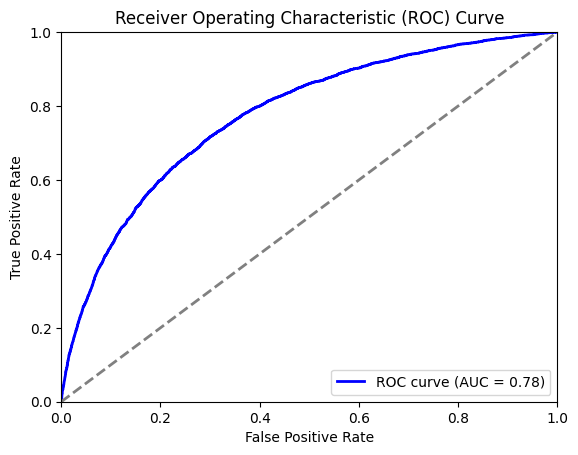

In [247]:
# from sklearn.metrics import roc_curve, precision_recall_curve
# fpr, tpr, thres = precision_recall_curve(y_val, y_pred_proba)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume y_test is the true labels and y_score is the predicted probabilities
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [162]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
# Create a submission DataFrame
submission = pd.DataFrame({'SK_ID_CURR': X_test.SK_ID_CURR, 'TARGET': y_pred_proba})
submission['SK_ID_CURR'] = submission['SK_ID_CURR'].astype('int32')
submission.set_index('SK_ID_CURR', inplace=True)
submission = submission.sort_index()
submission = submission.reset_index()

In [164]:
submission[['SK_ID_CURR', 'TARGET']].to_csv('submissionxxx.csv', index=False)
submission

,SK_ID_CURR,TARGET
0,5,0.046880
1,13,0.063330
2,16,0.037062
3,19,0.204644
4,25,0.116677
...,...,...
61497,307487,0.018721
61498,307490,0.015113
61499,307497,0.026521
61500,307499,0.037681
